# Desarrollo proyecto óptica: 
El proyecto desarrollado trata el tema de compresión con pérdida simulando un laboratorio digital, en particular implementaremos dos ténicas de compresión: 

* Compresión óptica: Método escalado óptica.
* Compresión digital: Método cuantización.

## Librerías: 

In [ ]:
# Librerías 
import numpy as np 
import scipy.fft as sft 
import matplotlib.pyplot as plt
from PIL import Image as im
import skimage as sk
import scipy.ndimage as sc

## Funciones a utilizar: 

In [ ]:
def tajada(M1,M2,x,y):
    """
    Esta funcion permite recortar una seccion centrada en x, y del array M1 de
    tamaño igual al array M2. Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo del que se recorta una sección.
    M2 : Array Numpy
        Arreglo que determina el tamaño del recorte.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a recortar o las coordenadas exceden el tamaño de la matriz original se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M2.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz recortada debe ser mas pequeña que la original')
    MC=M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((m+nn)*0.5)+x)]
    return MC

def fusion(M1,M2,x,y):
    """
    Esta funcion permite insertar M2 a una seccion centrada en (x, y) del array M1.
    Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo al que se inserta una sección.
    M2 : Array Numpy
        Arreglo a insertar.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a insertar o las coordenadas exceden el tamaño de la matriz original se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M1.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz a instertar debe ser mas pequeña que la original')
    M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((m+nn)*0.5)+x)]=M2
    MC=np.copy(M1)
    return MC

def convft(U,H,dx):
    """
    Realiza la convolucion 2D de las matrices U,H usando la transformada rapida de Fourier. U, H deben tener la misma forma.
    
    Parameters
    ----------
    U : Array Numpy
        Uno de las matrices a convolucionar
    H : Array Numpy
        Otra de las matrices a convolucionar
    dx : Float
        Tamaño de muestreo de las funciones a convolucionar. Necesario para preservar escala.

    Returns
    -------
    U2
        Arreglo de numpy con la convolucio de U y H

    """
    U2=sft.fft2(sft.fftshift(U))*(dx**2)
    U2=H*U2
    U2=sft.ifftshift(sft.ifft2(U2)*(1/dx**2))
    return U2


def circ(x,y,d): # FUNCION CÍRCULO
    out = np.zeros((len(x),len(y)))
    for cont in range(0,len(x)):
        for cont2 in range(0,len(y)):
            out[cont,cont2]=int(np.abs(np.sqrt(x[cont,cont2]**2+y[cont,cont2]**2)/d)<=1)
    return out
    
def propTF(u1,L,lam,z): # PROPAGADOR BASADO EN LA FUNCIÓN DE TRANSFERENCIA
    # propagation - transfer function approach
    # assumes same x and y side lengths and
    # uniform sampling
    # u1 - source plane field
    # L - source and observation plane side length
    # lambda - wavelength
    # z - propagation distance
    # u2 - observation plane field
    N=len(u1[0,:]) 
    dx=L/N
    k=2*np.pi/lam
    fx=np.arange(-1/(dx*2),1/(dx*2),1/L)  
    FX, FY = np.meshgrid(fx, fx);
    H=np.exp(-1j*np.pi*lam*z*(FX**2+FY**2))
    H= np.fft.fftshift(H)
    U1= np.fft.fft2(np.fft.fftshift(u1))
    U2= H*U1
    u2=np.fft.ifftshift(np.fft.ifft2(U2))
    return u2

## Generación del holograma simulando un sistema experimental utilizado en el laboratorio: 

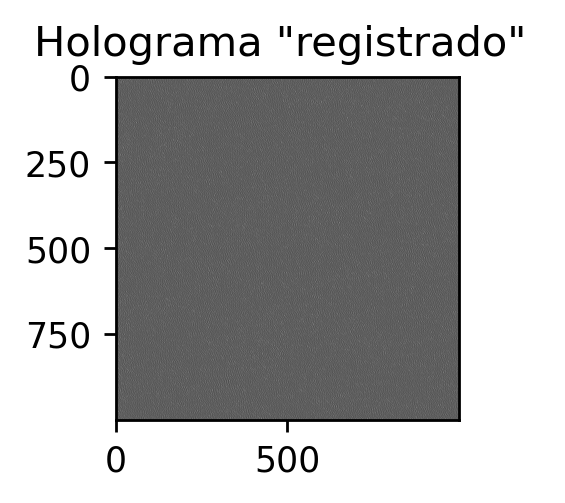

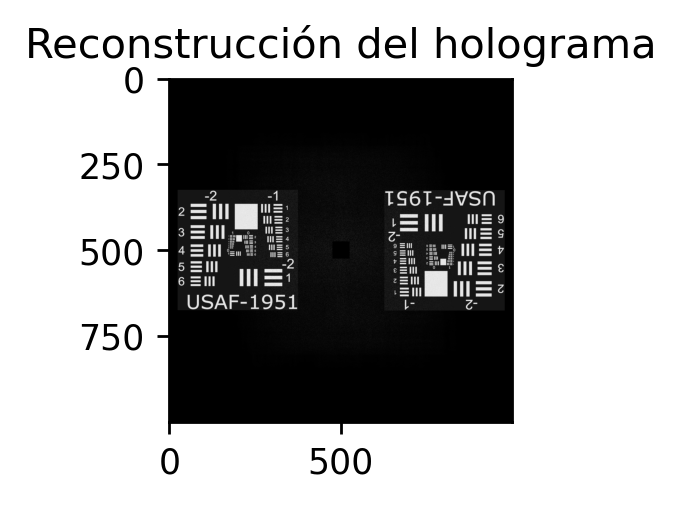

In [ ]:
'''Carguemos la imagen a trabajar'''
I = im.open('./usaf.bmp')

''' 
    Matriz aleatoria con valores arbitrarios, con tamaño del objeto, 
    actúa como una máscara de fase aleatoria
'''
A = np.random.rand(350, 350) 

I=I.resize([350,350]) # El objeto solo ocupará este ventana. Es necesario para que haya suficiente espacio a la hora de reconstruir el holograma
I=1-np.asarray(I)     # Cambio de contraste en la imagen usaf. 
I=I*1.                # Convierte nuestro objeto en una matriz de float. 

'''Normalicemos la imagen'''
I=I/np.max(np.max(I))
I=I-np.min(np.min(I))

'''Multiplicando la matriz por una máscara de fase aleatoria
    La siguiente línea nos muestra lo que comunmente se conoce como
    Objeto Difuso
'''
I = np.sqrt(I)* np.exp(1j*2*np.pi*A) #Campo de entrada I= Campo entrada


'''Campo de Entrada'''
ug=np.zeros([1000,1000])*1j #Campo de ceros, ventana 1000 x 1000 muestras. 

'''
    Ahora al campo de entrada vamos a pegarle la amplitud del objeto y una fase
    proporcional a este. Se pega a -200 muestras del centro de la ventana de 1000 x1000
    muestras. 

'''
ug=fusion(ug,I,-150,0) #Pegamos el campo(objeto difuso) en el campo de entrada

'''
    Marcamos un pixel con 1 en la dirección opuesta, simulando nuestra fuente
    puntual 'Hologramas de Gabor', se pone en la dirección opuesta a la cual 
    insertamos el objeto. 
    
    *1000 es para que la intensidad de la fuente puntual realice una buena interferencia
    con el objeto. 
'''
ug=fusion(ug,np.ones([1,1])*1000,150,0)


'''
    Transformada de Fourier de la ventana de entrada(campo de entrada). La transformada de este campo
    es la interferencia entre la transformada de la luz transmitida o reflejada por el objeto y la la 
    transformada de la fuente puntual. Esto es lo que se conoce como Holograma. 
'''

'''
    una onda de referencia y una onda reflejada o transmitida por un objeto interfieren
    sobre un medio que registra la intensidad de dicha interferencia.la intensidad de la interferencia
    de ambos campos en el plano de registro se define como el Holograma. 
'''

Uf = sft.fftshift(sft.fft2(sft.fftshift(ug))) #Holograma
H=Uf*np.conj(Uf) #Amplitud de la transformada 
H=abs(H)         #El abs() para asegurarnos de que no hayan errores de computo. 

'''Transformada para la reconstrucción del objeto'''
ui=sft.fftshift(sft.fft2(sft.fftshift(H)))
'''
    Se pone un filtro en el orden central de la reconstrucción para que 
    la visibilidad del objeto sea buena, dado que la intensidad de este orden
    central es muy alto
'''
ui=fusion(ui,np.zeros([50,50]),0,0)

'''Graficación '''
fig = plt.figure(dpi=250) # --> Gráfica de lo que registraría la camara CCD
ax1 = fig.add_subplot(2, 1, 1)
pos1 =ax1.imshow(H,cmap='gray')
ax1.title.set_text('Holograma "registrado" ')

fig = plt.figure(dpi=250)
ax1 = fig.add_subplot(2, 1, 2)
pos1 =ax1.imshow(np.abs(ui),cmap='gray')
ax1.title.set_text('Reconstrucción del holograma')

Text(0.5, 1.0, 'Imagen filtrada')

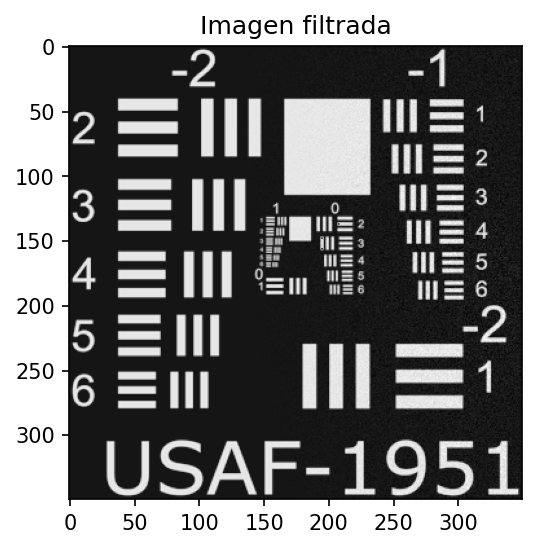

In [ ]:
# Dato filtrado
ug_filtrado=tajada(np.abs(ui),np.zeros([350,350]),-300,0)

plt.figure(dpi=150)
plt.imshow(ug_filtrado, cmap='gray')
plt.title('Imagen filtrada')

## Obtención del DCO: 

(1000, 1000)


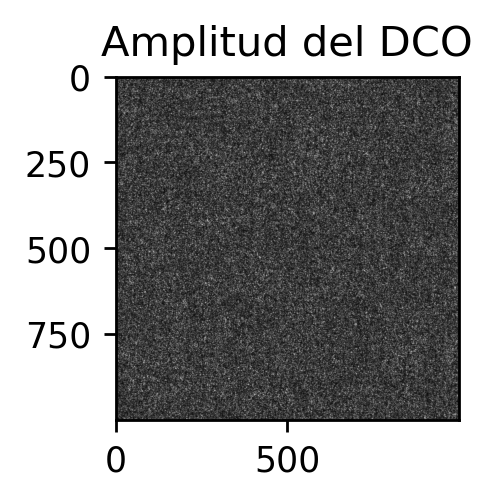

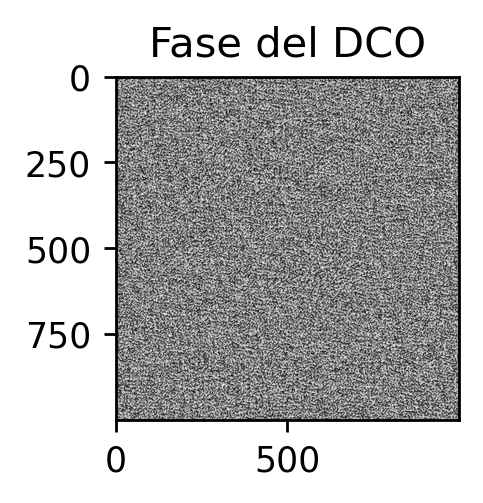

In [ ]:
'''
    De nuestro campo objeto(TF del holograma) recortamos el objeto en la misma ubicación 
    que cuando realizamos el filtrado
'''
R=tajada(ui,np.zeros([350,350]),-300,0)

'''
    Creamos una ventana de entrada que tiene el mismo tamaño del holograma pero en este caso
    ubicamos el recorte de nuestro campo objeto en el centro
'''
ug=np.zeros([1000,1000])*1j
ug=fusion(ug,R,0,0) #Pegamos la imagen recortada en la mitad de la ventana

'''Dato de campo óptico'''
DCO=sft.fftshift(sft.fft2(sft.fftshift(ug))) 
print(np.shape(DCO))
'''Amplitud del dato de campo óptico'''
amplitud_DCO = np.abs(DCO)
'''Fase del dato de campo óptico'''
fase_DCO=(np.angle(DCO)+np.pi)/(2*np.pi)

fig = plt.figure(dpi=250) # --> Gráfica de lo que registraría la camara CCD
ax1 = fig.add_subplot(2, 1, 1)
pos1 =ax1.imshow(amplitud_DCO,cmap='gray')
ax1.title.set_text('Amplitud del DCO')

fig = plt.figure(dpi=250)
ax1 = fig.add_subplot(2, 1, 2)
pos1 =ax1.imshow(fase_DCO,cmap='gray')
ax1.title.set_text('Fase del DCO')

## TF del DCO, obtención del campo objeto

In [ ]:
'''
    El campo objeto es el resultado de la TF del DCO, la diferencia entre la TF y la TFI
    en este caso es para la inversión del objeto 
'''
ug_objeto=sft.fftshift(sft.fft2(sft.fftshift(DCO)))

## Se introduce el campo objeto en una ventana que tiene dos veces el tamaño del holograma, esto con el fin de evitar las réplicas periódicas. 

In [ ]:
'''Campo de Entrada donde vamos a pegar nuestro DCO'''
ugv=np.zeros([2001,2001])*1j 
ugv1=fusion(ugv,ug_objeto,0,0) #La ventana para evitar réplicas periódicas. 

Dado lo que tenemos hasta el momento ya podemos empezar a trabajar con nuestro primer método de compresión que referencia el **escalado óptico**

## Técnica de compresión por medio del Escalado Óptico: 
La técnica de escalado óptico se basa en magnificar(escalar) por medio de una lente convergente el campo objeto obtenido a partir del DCO.
<img src='Escalado_optico.png'>

Donde podemos notar que $d_1$ es la distancia objeto, $d_2$ es la distancia imagen. $X_0$ y $Y_0$ representan las dimensiones de la imagen. 

Además de esto se define la magnificación como: 
$$M = \frac{-d_2}{d_1}$$
La cuál para poder escalar el DCO debe cumplirse que $0<M<1$. 

Para realizar el proceso de escalado óptico computacionalmente, primero debemos realizar la propagación del DCO hasta el plano de la lente convergente $d1$, luego la multiplicación por la fase de la lente y posteriormente una propagación $d_2$. Debemos tener en cuenta que en este caso $d_1>d_2$. 

In [ ]:
'''Paramétros'''
N = len(H[0,:]) 
N2 = N*2 #N tamaño del holograma, tamaño de la ventana 
wl = 532e-9 #Longitud de onda
k=2*np.pi/wl #Número de onda
dx = 8e-6 

zc= dx*N2/wl
print(zc,'Distancia critica')

#Paramétros no convenientes
#N2 = 0.26*2 #metros, al final es mi L
#N = len(ugv1[0,:])
#dx= N2/N
############
aumento= 0.8
y1 = 2*((dx*dx*N2)/wl)
y2 = y1*aumento #Distancia imagen 
f = (y1*y2)/(y1 + y2) #Foco imagen
#zc =dx*N2/wl #Distancia critica
print(y1, ':Distancia plano objeto')
print(y2, ':Distancia plano imagen')

30075.18796992481 Distancia critica
0.48120300751879697 :Distancia plano objeto
0.3849624060150376 :Distancia plano imagen


In [ ]:
'''
    Proceso de Escalado óptico
'''
# sistema de coordenadas
x=np.arange(-N2*dx/2,N2*dx/2,dx)
X,Y = np.meshgrid(x, x);
# Se propaga el campo objeto una distancia zo 
u2=propTF(ugv1,N2,wl,y1)
#Se multiplica por la fase de la lente
ww=4
uout=u2*np.exp(-1j*k/(2*f)*(X**2+Y**2));
#Se propaga una distancia zi hasta el plano imagen
u4=propTF(uout,N2,wl,y2)

DCO_M08=u4

'''
    TF del campo objeto después de haber escalado de esta forma obtenemos el DCO escalado
'''
DCO_M08=sft.fftshift(sft.fft2(sft.fftshift(DCO_M08)))

## Se hace un recorte sobre el DCO escalado, con base a la magnificación. 

In [ ]:
'''El recorte se hace de [800,800] ya que estamos trabajando con una magnificación de 0.8'''
RM08=tajada(DCO_M08,np.zeros([800,800]),0,0)  

## Se guarda la fase y la amplitud. 

In [ ]:
'''Amplitud del dato de campo óptico'''
amplitud_DCO08 = np.abs(RM08)
amplitud_DCO08 = amplitud_DCO08/np.max(np.max(amplitud_DCO08))*1. #Normalizo la amplitud
amplitud_DCO08 = amplitud_DCO08*255. 

'''Fase del dato de campo óptico'''
fase_DCO08=(np.angle(RM08)+np.pi)/(2*np.pi) #Normalizo la fase
fase_DCO08= fase_DCO08*255. 

'''Guardamos la imagen de la amplitud'''
amplitud08=im.fromarray(np.uint8(amplitud_DCO08))
amplitud08.save('amplitudM08.bmp')

'''Guardamos la imagen de la fase'''
fase08=im.fromarray(np.uint8(fase_DCO08))
fase08.save('faseM08.bmp')

## Cargamos la fase y la amplitud

In [ ]:
'''Cargo la imagen de amplitud y la normalizo'''
amplitud08=im.open('amplitudM08.bmp')
amplitud08=np.asarray(amplitud08)
amplitud08=amplitud08/255.

'''Cargo la imagen de fase y la normalizo'''
fase08=im.open('faseM08.bmp')
fase08=np.asarray(fase08)
fase08=fase08/255. 

In [ ]:
'''Proceso de reconstrucción de la imagen y escalado inverso'''
DCO08=amplitud08*np.exp(1j*2*np.pi*(fase08-0.5)) #para la reconstrucción de la imagen

'''
    Primero creamos un campo de entrada del doble del tamaño de nuestro DCO escalado dado que nuestro
    DCO_escalado a 0.8 tiene un tamaño de [800,800] creamos un espacio de [1600,1600]. Esto con el fin,
    de evitar las convoluciones periódicas en el proceso de escalado inverso. 
'''
ugv08=np.zeros([2001,2001])*1j 
ugv108=fusion(ugv08,DCO08,0,0) #La ventana para evitar réplicas periódicas. 

## Se realiza la transformada de Fourier inversa para pasar del DCO escalado al objeto escalado.



In [ ]:
ug_M08=sft.fftshift(sft.fft2(sft.fftshift(ugv108))) #Objeto escalado

## Se realiza el proceso de escalado inverso: 

In [ ]:
# Se propaga el objeto escalado una distancia zo 
u208=propTF(ug_M08,N2,wl,y2)
#Se multiplica por la fase de la lente
ww=4
uout=u208*np.exp(-1j*k/(2*f)*(X**2+Y**2));
#Se propaga una distancia zi hasta el plano imagen
u4=propTF(uout,N2,wl,y1)

ug08_EI = u4 #Hasta aquí el proceso de escalado inverso

## Objeto reconstruido con la escala original.

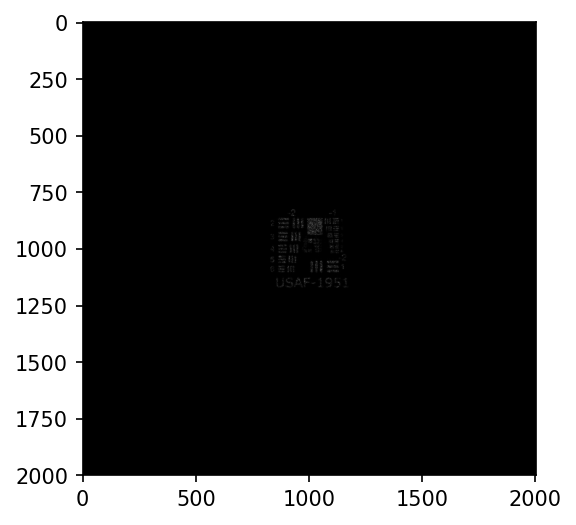

In [ ]:
'''Realizamos la transformada inversa después de hacer el proceso de escalado óptico'''

reconstruccion = ug08_EI*np.conj(ug08_EI)
reconstruccion = abs(reconstruccion)

plt.figure(dpi=150)
plt.imshow(reconstruccion, cmap='gray')

Text(0.5, 0, 'M=0.8')

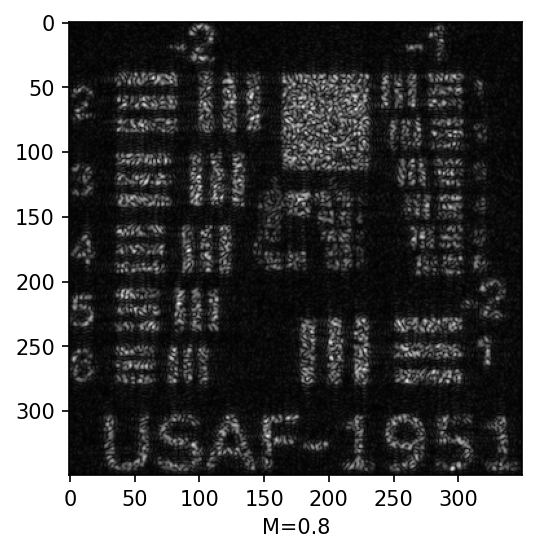

In [ ]:
'''Dato obtenido '''
ug_final=tajada(reconstruccion,np.zeros([350,350]),0,0)

plt.figure(dpi=150)
plt.imshow(ug_final**0.5, cmap='gray')
plt.xlabel('M=0.8')

In [ ]:
def quantize(U,bits): 
    '''
        La función quantize se ingresa un campo normalizado y con valores entre 0 y 255.
    '''
    bits = 2**bits 
    x1 = np.linspace(0,255,256) #Arreglo que representa los niveles de intensidad a 8 bits. 
    x2 = np.linspace(0, 255, bits) #Creó el arreglo con el que vamos a cuantizar
    '''
        Dado que introducimos una imagen bidimensional entonces debemos debemos cuantizar los valores de cada
        una de estas, mediante un muestreo uniforme. 
    '''
    Matrix = np.zeros([len(U),len(U)])
    for i in range(0,len(U)): 
        B = U[i,:]
        C = x2[np.absolute(B[:,np.newaxis]-x2).argmin(axis=1)] #Proceso de redondeo
        Matrix[i,:]= C
    
    return Matrix

## Coeficiente de correlación en el caso de escalado óptico: 

In [ ]:
#Implementación coeficiente de correlación 
def corr2(A,B):
    e=0
    s1=0
    s2=0
    Am=np.mean(A)
    Bm=np.mean(B)
    [n,m]=np.shape(A)
    for i in range(0,n):
        for j in range(0,m):
            e=e+(A[i,j]-Am)*(B[i,j]-Bm)
            s1=s1+(A[i,j]-Am)**2
            s2=s2+(B[i,j]-Bm)**2
    s=np.sqrt(s1*s2)
    return e/s

c1 = corr2(ug_filtrado, ug_final)
print(c1, ':coeficiente de correlación entre las imágenes')

0.5870779874936698 :coeficiente de correlación entre las imágenes


## Gráficas en términos de la magnificación y el volumen de datos

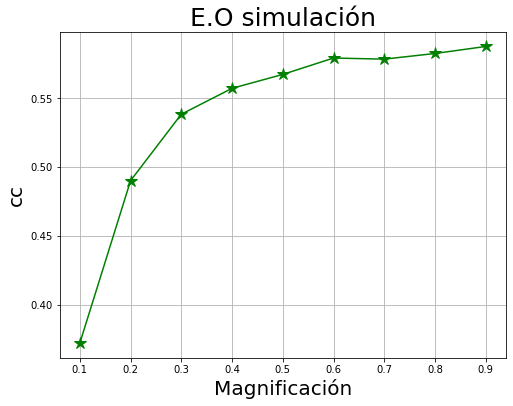

In [ ]:
ccM=np.array((0.5874,0.5823,0.5782,0.5790,0.5671,0.5570,0.5382,0.4900,0.3721))
MH = np.linspace(0.9,0.1,9)

plt.figure(figsize=(8,6))
plt.plot(MH,ccM,color='green',marker='*',markersize=13)
plt.title('E.O simulación',fontsize=25)
plt.xlabel('Magnificación', fontsize=20)
plt.ylabel('cc', fontsize=20)
plt.grid()

## Volumen de datos:
En el caso de escalado óptico podemos calcular el volumen como: 
$$V_{EO}= 2X_oY_oM^2B_c$$
En este caso $X_o$, $Y_o$ representan la resolución horizontal y vertical respectivamente del DCO. $M$ representa la magnificación, $B_c$ la profundidad de bits, que en este caso siempre es igual a 1 Byte.

In [ ]:
def V_EOsimulado(M): 
    Xo = 1000 #px, resolución horizontal del DCO
    Yo = 1000 # px, resolución vertical del DCO 
    lista=[]
    for i in M:
        V = float(2*Xo*Yo*(i**2))
        lista.append(V)
        VEO = np.array(lista)
        
    return VEO

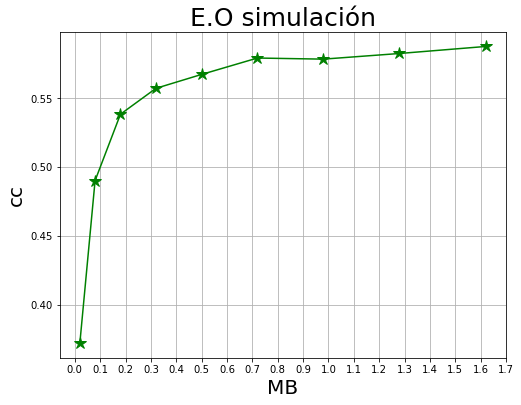

In [ ]:
B = V_EOsimulado(MH)*1e-6
plt.figure(figsize=(8,6))
plt.plot(B,ccM,color='green',marker='*',markersize=13)
plt.title('E.O simulación',fontsize=25)
plt.xlabel('MB', fontsize=20)
plt.ylabel('cc', fontsize=20)
plt.xticks(np.arange(0.0,1.8,0.1))
plt.grid()

## Comparación entre las diferentes técnicas de compresión: 

In [ ]:
def V_EOsimulado(M): 
    Xo = 1000 #px, resolución horizontal del DCO
    Yo = 1000 # px, resolución vertical del DCO 
    lista=[]
    for i in M:
        V = float(2*Xo*Yo*(i**2))
        lista.append(V)
        VEO = np.array(lista)
        
    return VEO

C = V_EOsimulado(M1)*1e-6
Byte = np.array((0.87,0.75,0.62,0.5,0.37,0.25))
lista=[]
def V_cuantizacion(Byte): 
    Xo = 1000 #px, resolución horizontal del DCO
    Yo = 1000 # px, resolución vertical del DCO 
    for i in Byte:
        V = float(2*Xo*Yo*i)
        lista.append(V)
        V_cuantizacion = np.array(lista)
        
    return V_cuantizacion
A=V_cuantizacion(Byte)*1e-6 #MegaByte

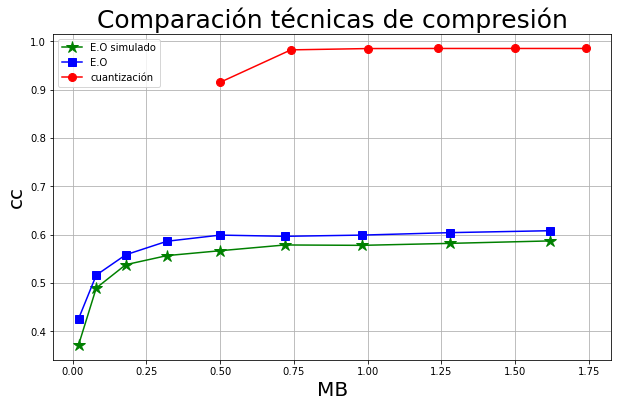

In [ ]:
'''Datos técnica simulación E.O'''
ccM=np.array((0.5874,0.5823,0.5782,0.5790,0.5671,0.5570,0.5382,0.4900,0.3721))
MH = np.linspace(0.9,0.1,9)

'''Datos técnica E.O obteniendo el holograma directamente'''
cc1=np.array((0.6085,0.6045,0.5994,0.5969,0.5994,0.5867,0.5587,0.5166,0.4263))
M1= np.linspace(0.9,0.1,9)

'''Datos técnica de cuantización'''
bits = np.array((0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1))
cc = np.array((0.9855,0.9855,0.9855,0.9853,0.9826,0.9155))

plt.figure(figsize=(10,6))
plt.plot(B,ccM,color='green',marker='*',markersize=13,label='E.O simulado')
plt.plot(C,cc1,color='blue',marker='s',markersize=8,label='E.O')
plt.plot(A,cc,color='red',marker='o',markersize=8,label='cuantización')
plt.title('Comparación técnicas de compresión',fontsize=25)
plt.xlabel('MB',fontsize=20)
plt.ylabel('cc',fontsize=20)
plt.legend()
plt.grid()